In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [2]:
keras.backend.clear_session()

In [3]:
!ls -l Data/

total 4
drwxr-xr-x 1 Kamilko 197121 0 Jul 16 10:09 check
drwxr-xr-x 1 Kamilko 197121 0 Jul 15 14:29 test
drwxr-xr-x 1 Kamilko 197121 0 Jul 15 14:29 train
drwxr-xr-x 1 Kamilko 197121 0 Jul 17 11:16 valid


The system cannot find the path specified.


In [4]:
train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True)
valid_data_gen = ImageDataGenerator(rescale=1./255, 
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory('Data/train', 
                                                     target_size=(299, 299), 
                                                     batch_size=32, 
                                                     class_mode='binary')
valid_generator = valid_data_gen.flow_from_directory('Data/valid', 
                                                     target_size=(299,299), 
                                                     batch_size=32, 
                                                     class_mode='binary')
test_generator = test_data_gen.flow_from_directory('Data/test', 
                                                   target_size=(299,299), 
                                                   batch_size=32, 
                                                   class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 428 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [5]:
print(train_generator.class_indices)
print(valid_generator.class_indices)
print(test_generator.class_indices)

{'banana': 0, 'not-banana': 1}
{'banana': 0, 'not-banana': 1}
{'banana': 0, 'not-banana': 1}


In [6]:
train_steps = train_generator.n // train_generator.batch_size
valid_steps = valid_generator.n // valid_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

In [7]:
checkpointer = ModelCheckpoint(filepath='Checkpoint/weigths.hdf5', verbose=1,save_best_only=True)

## Define model

In [8]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(299,299,3), padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 99, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 99, 99, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [11]:
history = model.fit(train_generator, 
                    steps_per_epoch=train_steps,
                    epochs=10, 
                    validation_data=valid_generator, 
                    validation_steps=valid_steps, 
                    verbose=1, 
                    callbacks=[checkpointer])

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.6927 - binary_accuracy: 0.6862
Epoch 00001: val_loss improved from inf to 0.54941, saving model to Checkpoint/weigths.hdf5
50/50 [==============================] - 412s 8s/step - loss: 0.6927 - binary_accuracy: 0.6862 - val_loss: 0.5494 - val_binary_accuracy: 0.7452
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.5108 - binary_accuracy: 0.7744
Epoch 00002: val_loss improved from 0.54941 to 0.47895, saving model to Checkpoint/weigths.hdf5
50/50 [==============================] - 401s 8s/step - loss: 0.5108 - binary_accuracy: 0.7744 - val_loss: 0.4790 - val_binary_accuracy: 0.7692
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.4962 - binary_accuracy: 0.7944
Epoch 00003: val_loss improved from 0.47895 to 0.45412, saving model to Checkpoint/weigths.hdf5
50/50 [==============================] - 426s 9s/step - loss: 0.4962 - binary_accuracy: 0.7944 - val_loss: 0.4541 - val_binar

In [12]:
!ls -l Checkpoint/

total 924372

The system cannot find the path specified.



-rw-r--r-- 1 Kamilko 197121 946554400 Jul 17 13:47 weigths.hdf5


In [13]:
model.load_weights('./Checkpoint/weigths.hdf5')

In [14]:
model.evaluate(test_generator, verbose=1, steps=test_steps)

5/5 [==============================] - 7s 1s/step - loss: 0.4404 - binary_accuracy: 0.7937


[0.44041094183921814, 0.793749988079071]

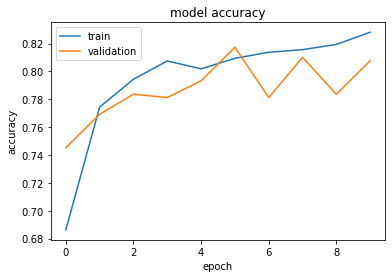

In [15]:
# history of accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

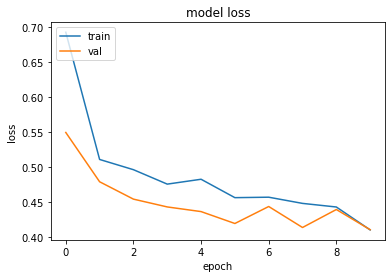

In [16]:
# history of loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()